# This notebook is for testing work with PointingGroups

In [12]:
import pointings

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from astropy import time
import numpy as np

In [3]:
# load pointings
pg = pointings.PointingGroups.load("test")

In [ ]:
pg.groups = sorted(pg.groups, key=len, reverse=True)
pg[1]

In [85]:
def plot_pointings(visit_id, ra, dec):
    arcsec2degree = 0.000277778
    pixscale = 0.2637 #arcsec/px
    
    height   = 2048 * pixscale * arcsec2degree
    width    = 4096 * pixscale * arcsec2degree
    angle    = [0]*len(ra)

    fig, ax = plt.subplots(figsize=(13, 9))

    rect_patches = []
    for i, r, d, a in zip(visit_id, ra, dec, angle):
        # this will likely kill the notebook
        #annot = ax.text(r-0.001, d-0.001, i, fontsize=12)
        #                 lower left corner        height  width  angle
        rect = Rectangle((r-height/2., d-width/2.), height, width, a)
        rect_patches.append(rect)
    rect_patches_collection = PatchCollection(rect_patches, alpha=0.1)
    ax.add_collection(rect_patches_collection)

    ax.scatter(ra, dec, color="red")

<IPython.core.display.Javascript object>


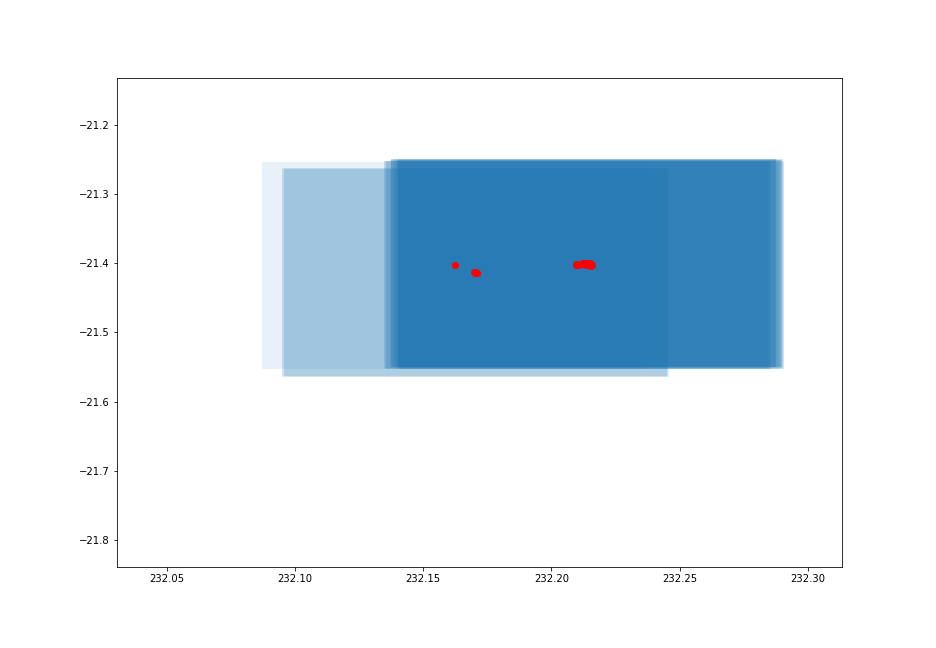

In [86]:
# make a plot of all pointings 
visit_id = pg.table["visit_id"]
ra       = pg.table["ra"]
dec      = pg.table["dec"]
plot_pointings(visit_id, ra, dec)

<IPython.core.display.Javascript object>


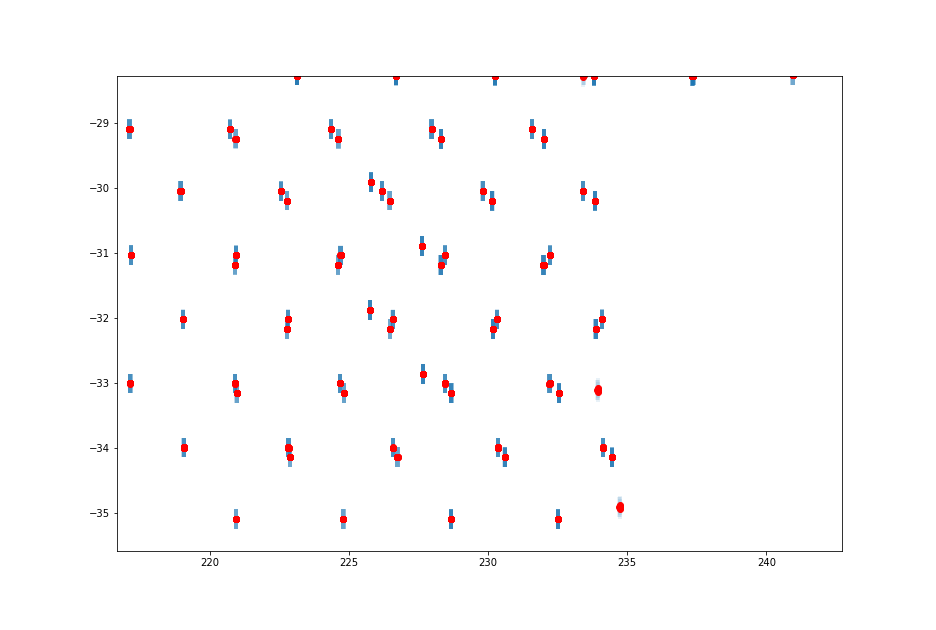

In [15]:
# recreate that plot for grouped pointings only (shouldn't be a lot of difference)
visit_id = pg["visit_id"]
ra       = pg["ra"]
dec      = pg["dec"]
plot_pointings(visit_id, ra, dec)

In [91]:
# Pairs are created from grouped pointings by iterating through all the pointings in a group and calculating the
# time difference dt between two exposures. The pair that has the largest dt will be image differenced. 
# For testing purposes we start from the pointing ra, dec = (207.354958, -7.519750). 
foi = pg[0]
pairs = []

for science in foi:
    sci_obsdate = science["date_obs"]
    sci_id = science["visit_id"]
    sci_ra = science["ra"]
    sci_dec = science["dec"]
    sci_filename = science["filename"]
    sci_date = time.Time(sci_obsdate.decode("utf-8"))
    
    maxdt = 0 
    for template in foi: 
        tmplt_obsdate = template["date_obs"]
        tmplt_id = template["visit_id"]
        tmplt_ra = template["ra"]
        tmplt_dec = template["dec"]
        tmplt_filename = template["filename"]
        tmplt_date = time.Time(tmplt_obsdate.decode("utf-8"))
        
        # dt is a astropy.time.TimeDelta object and can not be compared to non TimeDelta objects
        # it recognizes positive and negative time delta so we check for its absolute value
        dt = sci_date - tmplt_date  
        if abs(dt) > time.TimeDelta(maxdt, format="sec"):
            maxdt = dt
            if sci_id != tmplt_id:
                pair = (science[1], template[1], abs(dt))   
        pairs.append(pair)
    maxdt = time.TimeDelta(0, format="sec")

In [92]:
pairs

[(b'2015-05-19',
  b'2015-05-19',
  <TimeDelta object: scale='tai' format='jd' value=0.00856758101851851>),
 (b'2015-05-21',
  b'2015-05-21',
  <TimeDelta object: scale='tai' format='jd' value=0.0034857175925926964>),
 (b'2015-05-21',
  b'2015-05-22',
  <TimeDelta object: scale='tai' format='jd' value=0.9992866782407407>),
 (b'2015-05-21',
  b'2015-05-22',
  <TimeDelta object: scale='tai' format='jd' value=0.995812673611111>),
 (b'2015-05-21',
  b'2015-05-21',
  <TimeDelta object: scale='tai' format='jd' value=0.00646702546296285>),
 (b'2015-05-21',
  b'2015-05-21',
  <TimeDelta object: scale='tai' format='jd' value=0.009818333333333262>),
 (b'2015-05-21',
  b'2015-05-21',
  <TimeDelta object: scale='tai' format='jd' value=0.0032476504629629366>),
 (b'2015-05-21',
  b'2015-05-22',
  <TimeDelta object: scale='tai' format='jd' value=1.0091166087962962>),
 (b'2015-05-21',
  b'2015-05-22',
  <TimeDelta object: scale='tai' format='jd' value=1.002761400462963>),
 (b'2015-05-21',
  b'2015-05-

In [84]:
len(pg.table)

13479

In [20]:
# check if all pairs make sense, third columns is the dt in hours
for pair in pairs:
    print(pair[0]["visit_id"], pair[1]["visit_id"], pair[2].sec/60./60.)

In [126]:
# Create the image differencing scripts in folder jobs

rerunpath = "/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/r207.354958d-7.519750/Processed_Data/rerun/singleFrameDriver_rerun"

ncpu = 20
outpath = "imdiff_r207.354958d-7.519750"
cfgfile = "config.py"
cmd = ("imageDifference.py {rerunpath} -j {ncpu} --output {outpath} -C {cfgfile} --longlog "+
       "--timeout 18000 --id visit={visitid} --templateId visit={templateid}\n")

with open("jobs/jobs_specialty.sh", "w") as f:
    for pair in pairs:
        f.write(cmd.format(rerunpath=rerunpath, ncpu=ncpu, outpath=outpath, cfgfile=cfgfile, 
                           visitid=int(pair[0]["visit_id"]), templateid=int(pair[1]["visit_id"])))